<a href="https://colab.research.google.com/github/nebojsa-bozanic/BMI_OSuM/blob/master/Vezba9%3A%20Obrada%20rendgenske%20slike%3A%20Toniranje%20snimaka/OSuM_vezba_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Obrada slike u medicini (BMI)</h1>

Literatura: https://moodle.telekom.ftn.uns.ac.rs/course/view.php?id=82


Laboratorijska vežba 9: Obrada rendgenske slike: Toniranje snimaka

Potrebne biblioteke: cv2, numpy, matplotlib.pyplot, pydicom, osum

In [3]:
!git clone https://github.com/nebojsa-bozanic/BMI_OSuM.git
%cd /content/BMI_OSuM/Vezba9: Obrada rendgenske slike: Toniranje snimaka

Cloning into 'BMI_OSuM'...
remote: Enumerating objects: 836, done.
remote: Counting objects: 100% (230/230), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 836 (delta 103), reused 125 (delta 57), pack-reused 606
Receiving objects: 100% (836/836), 278.52 MiB | 19.20 MiB/s, done.
Resolving deltas: 100% (290/290), done.
Updating files: 100% (245/245), done.
/content/BMI_OSuM/Vezba9: Obrada rendgenske slike: Toniranje snimaka


In [4]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.8 MB/s eta 0:00:00


In [5]:
import numpy as np
import osum
import matplotlib.pyplot as plt
import pydicom

# 1. Logaritamska kompresija i MSE

1.1 Učitati sirovu sliku Ro_01.fxd i uraditi logaritamsku kompresiju opsega (im_log).

Text(0.5, 1.0, 'Logaritamska kompresija opsega')

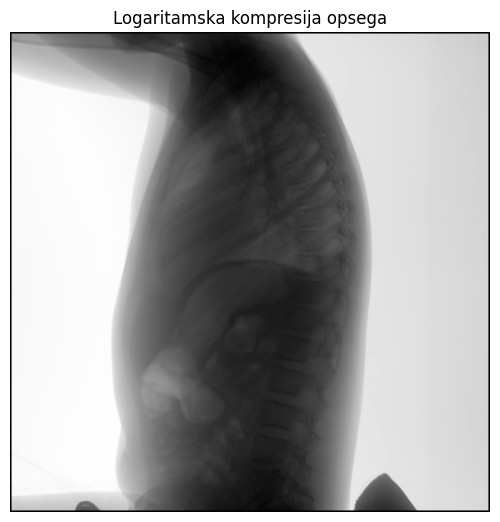

In [6]:
# 1.1
[im, DetInfo, hdr] = osum.read_raw('Ro_01.fxd')

logLUT = osum.log_LUT(16384, 4096, 0.001)
im_log = logLUT[im]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.imshow(im_log, cmap='gray', vmin=im_log.min(), vmax=im_log.max())
plt.axis('off')
plt.title('Logaritamska kompresija opsega')

1.2 Od slike im_log napraviti Laplasovu piramidu od 4 nivoa.

In [7]:
# 1.2
Lpyr, Gyr, Res, size_vec = osum.im_pyr_decomp(im_log, 4)

1.3 Detalje na prvom nivou pojačati sigmoidalnom transformacijom sa direktnim
potiskivanjem šuma (lazni opseg -2000 do 2000, izlazni opseg -800 do 800, nagib 7 i ukupno 10 % vrednosti oko nule suzbiti). Detalje na drugom nivou pojačati
sigmoidalnom transformacijom sa ublaženim pojačanjem (isti parametri kao
prethodno). Na treći i četvrti nivo primeniti običnu sigmoidalnu transformaciju, ali detalje na trećem pojačati više (nagib 7) nego na četvrtom nivou (nagib 3).

In [8]:
# 1.3
sigLUT_z = osum.sigmLUT_z(2000, 800, 7, 0.05)
sigLUT_lin = osum.sigmLUT_lin(2000, 800, 7, 0.05)
sigLUT1 = osum.sigmLUT(2000, 800, 7)
sigLUT2 = osum.sigmLUT(2000, 800, 3)

Lpyr[0] = sigLUT_z[np.uint16(Lpyr[0]+2000)]
Lpyr[1] = sigLUT_lin[np.uint16(Lpyr[1]+2000)]
Lpyr[2] = sigLUT1[np.uint16(Lpyr[2]+2000)]
Lpyr[3] = sigLUT2[np.uint16(Lpyr[3]+2000)]

1.4 Rekonstruisati ovako izmenjenu piramidu u sliku im_mse i prikazati tu sliku.

Text(0.5, 1.0, 'MSE')

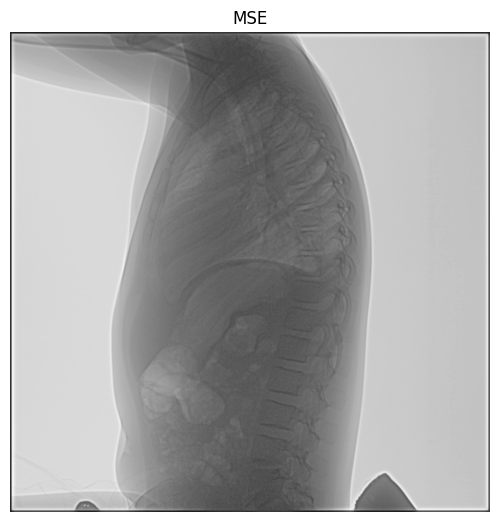

In [9]:
# 1.4
im_mse = osum.im_pyr_recon(Lpyr, Res, size_vec)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.imshow(im_mse, cmap='gray', vmin=im_mse.min(), vmax=im_mse.max())
plt.axis('off')
plt.title('MSE')

# 2. Linearno toniranje

2.1 Napraviti i prikazati histogram im_mse.

Text(0.5, 1.0, 'Histogram MSE slike')

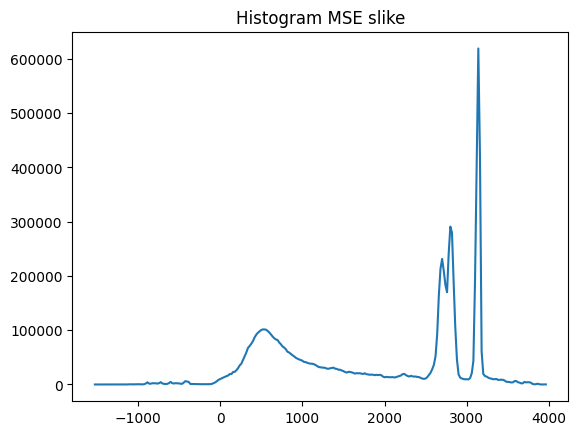

In [10]:
# 2.1
g = np.arange(round(im_mse.min()), round(im_mse.max())+1, 20)
h = np.histogram(im_mse, g)
plt.figure()
plt.plot(g[:-1], h[0])
plt.title('Histogram MSE slike')

2.2 Vizuelnom analizom histograma odraditi granice za toniranje.

In [11]:
# 2.2
Lmin = -350
Lmax = 3000

2.3 Primeniti granice toniranja tako da sve ispod donje i sve iznad gornje ode u zasićenje. Takođe invertovati sliku kako bi se dobio uobičajeni prikaz rtg slike i korigovati izlazni opseg na [0, 255]. Dobijenu sliku nazvati im_ts1. Prikazati sliku.

2.4 Prikazati sliku im_ts1.

Text(0.5, 1.0, 'Linearno toniranje 1')

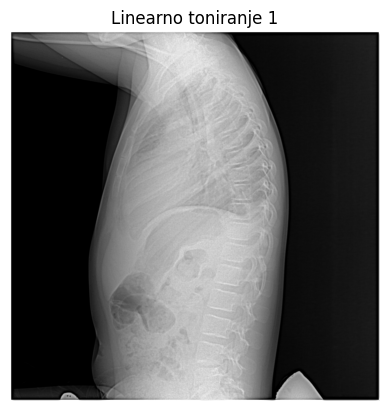

In [12]:
# 2.3
im_ts1  =im_mse
im_ts1[im_ts1<Lmin] = Lmin
im_ts1[im_ts1>Lmax] = Lmax
im_ts1 = (1-osum.im_norm(im_ts1))*255

# 2.4
plt.figure()
plt.imshow(im_ts1, cmap='gray', vmin=im_ts1.min(), vmax=im_ts1.max())
plt.axis('off')
plt.title('Linearno toniranje 1')

2.5 Napraviti kumulativnu sumu normalizovanog histograma i analizirati je paralelno sa normalizovanim histogramom. Šta predstavljaju vrednosti na ovom grafiku?

2.6 U modulu osum napraviti funkciju stat_hist_lims_fromh koja vraća granice intenziteta za toniranje na osnovu prosleđene količine (procenta) najsvetlijih i najtamnijih piksela koje želimo da odvedemo u zasićenje. Ulazni parametri funkcije su još i normalizovani histogram i vektor granica histograma.

Text(0.5, 1.0, 'Kumulativni histogram')

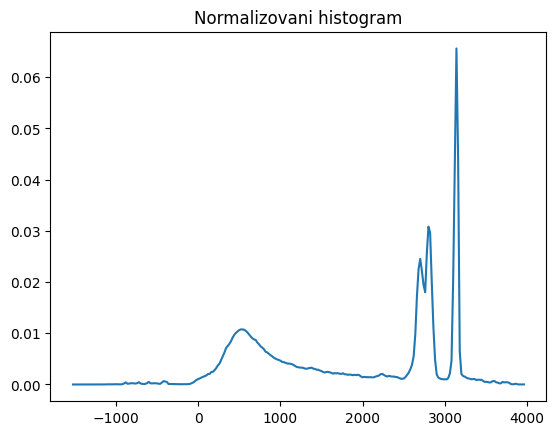

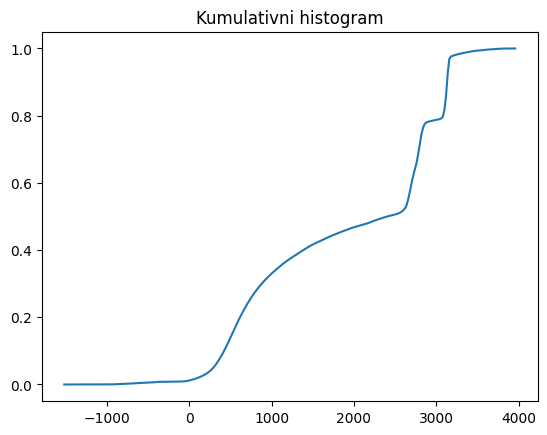

In [13]:
# 2.5
hn = h[0]/np.sum(h[0])
ch = np.cumsum(hn)
plt.figure()
plt.plot(g[:-1], hn)
plt.title('Normalizovani histogram')

plt.figure()
plt.plot(g[:-1], ch)
plt.title('Kumulativni histogram')

2.7 Pomoću funckije napravljene u prethodnom koraku pronaći Lmin i Lmax tako da se 0.1% najtamnijih i 1% najsvetlijih intenziteta odvede u zasićenje (isporbati posle različite parametre i pratit promene). Koliko se razlikuju ovako dobijene vrednosti Lmin i Lmax i one korišćene u 2.2? Koristeći ove granice tonirati sliku (kao u 2.3) i smestiti je u promenljivu im_ts2. Prikazati sliku.

Text(0.5, 1.0, 'Linearno toniranje 2')

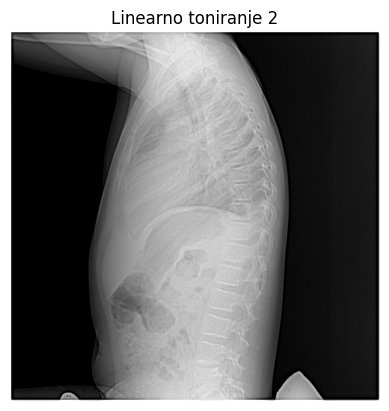

In [14]:
# 2.7
limits = osum.stat_hist_lims_fromh(hn, g[:-1], [0.001, 0.01])
Lmin = limits[0]
Lmax = limits[1]

im_ts2 = im_mse
im_ts2[im_ts2<Lmin] = Lmin
im_ts2[im_ts2>Lmax] = Lmax
im_ts2 = np.uint8((1-osum.im_norm(im_ts2))*255)

plt.figure()
plt.imshow(im_ts2, cmap='gray')
plt.axis('off')
plt.title('Linearno toniranje 2')

2.8 Učitati DICOM fajl 00044.dcm i istonirati CT sliku koja se nalazi u njemu koristeći vrednosti atributa W (WindowWidth) i L (WindowCenter). Slika se tonira tako da se zadrži opseg sa centrom u L širine W, a ostatak se odvodi u zasićenje. Takođe je u pitanju linearno toniranje, ali se Lmin i Lmax indirektno definišu, preko L i W. Prikazati sliku pre i nakon toniranja. Da li se poboljšao prikaz nakon toniranja?

Text(0.5, 1.0, 'CT nakon toniranja')

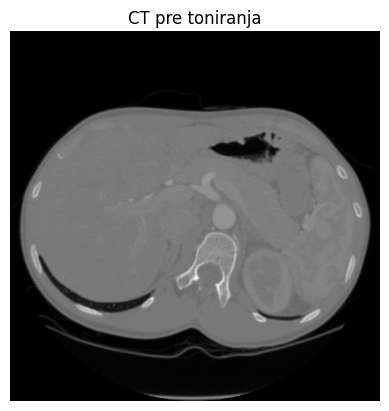

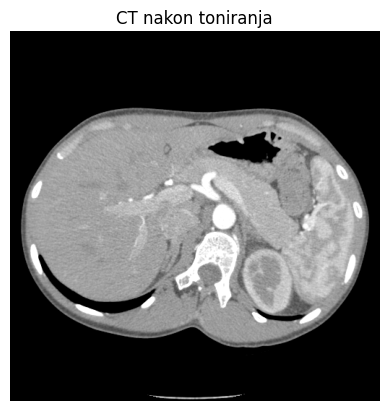

In [15]:
# 2.8
dc = pydicom.dcmread('00044.dcm')
im = dc.pixel_array

plt.figure()
plt.imshow(im, cmap='gray', vmin=im.min(), vmax=im.max())
plt.axis('off')
plt.title('CT pre toniranja')

L = int(dc.WindowCenter[0])
W = int(dc.WindowWidth[0])
Lmin = L-0.5*W
Lmax = L+0.5*W

im[im<Lmin] = Lmin
im[im>Lmax] = Lmax

plt.figure()
plt.imshow(im, cmap='gray', vmin=Lmin, vmax=Lmax)
plt.axis('off')
plt.title('CT nakon toniranja')

# 3. Sigmoidalno toniranje

3.1 U modulu osum napraviti funkciju ts_sigma koja implementira sigmoidalno toniranje. Ovakva transformacija treba dodatno da razvuče kontrast u svom centralnom delu. Transformaciju treba implementirati preko LUT. Ulazni parametri funkcije su slika koja se tonira, vektor parametara kapa (kontroliše nagib) i sigma (pomera sigmoid levo-desno) i gornja granica izlaznog opsega.

3.2 Primentiti ovu funkciju na im_mse kako bi se dobila im_ts3. Koristiti paramtere kapa=0.5 i sigma=3 (možete isprobati i druge vrednosti) i gornju granicu izlaznog opsega 4096. Prikazati sliku nakon toniranja.

Text(0.5, 1.0, 'Sigmoidalno toniranje')

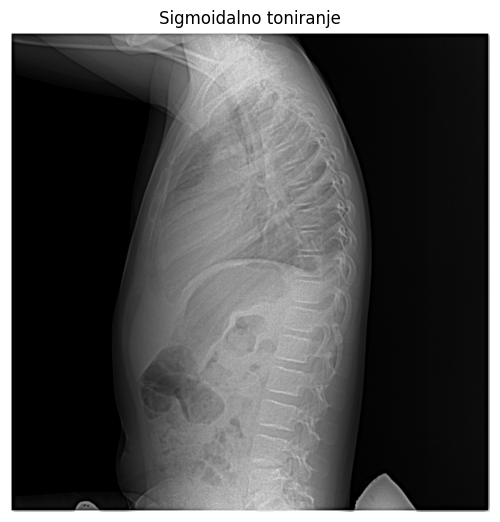

In [16]:
# 3.2
im_ts3 = osum.ts_sigma(im_mse, [0.5, 3], 4096)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.imshow(im_ts3, cmap='gray', vmin=im_ts3.min(), vmax=im_ts3.max())
plt.axis('off')
plt.title('Sigmoidalno toniranje')
